# COCO Reader

This reader operator reads a COCO dataset, or subset of COCO, which consists of an annotation file and the images directory.

The `DALI_EXTRA_PATH` environment variable should point to the location where data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded.

**Important**: Ensure that you check out the correct release tag that corresponds to the installed version of DALI.

In [1]:
from nvidia.dali import Pipeline, pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import numpy as np
import os.path

test_data_root = os.environ['DALI_EXTRA_PATH']
file_root = os.path.join(test_data_root, 'db', 'coco', 'images')
annotations_file = os.path.join(test_data_root, 'db', 'coco', 'instances.json')
batch_size = 4

In [2]:
pipe = Pipeline(batch_size=batch_size, num_threads=4, device_id=0)
with pipe:
    jpegs, bboxes, labels, polygons, vertices = fn.readers.coco(
        file_root=file_root,
        images=['cat-2083492_1280.jpg', 'pug-690566_1280.jpg', 'horse-60153_1280.jpg', 'animal-3099035_1280.jpg'],
        annotations_file=annotations_file,
        polygon_masks=True,
        ratio=True)
    images = fn.decoders.image(jpegs, device="mixed", output_type=types.RGB)
    pipe.set_outputs(images, bboxes, labels, polygons, vertices)                                                      

In [3]:
pipe.build()
pipe_out = pipe.run()                                                

images_cpu = pipe_out[0].as_cpu()
bboxes_cpu = pipe_out[1]
labels_cpu = pipe_out[2]
polygons_cpu = pipe_out[3]
vertices_cpu = pipe_out[4]

The operator returns bounding boxes as 2D arrays of `float`. The inner dimension contains `[x, y, width, height]` by default. When `ltrb` parameter is set to `True`, the inner dimesion contains `[left, top, right, bottom]`.

In [4]:
bboxes = bboxes_cpu.at(0)
labels = labels_cpu.at(0)
for bbox, label in zip(bboxes, labels):
    x, y, width, height = bbox
    print(f"Bounding box (x={x}, y={y}, width={width}, height={height}), label={label}")

Bounding box (x=0.17265625298023224, y=0.1690140813589096, width=0.34453123807907104, height=0.815621018409729), label=7


The mask polygons are defined by two outputs: polygons and vertices. Each entry in polygons contains three integers, representing the mask index that the polygon belongs to, the start vertex index and one past the last vertex index that belongs to the polygon. Each entry in vertices contains coordinates (x, y) representing a polygon vertex.

In [5]:
polygons = polygons_cpu.at(0)
vertices = vertices_cpu.at(0)
print(polygons.shape, vertices.shape)

(1, 3) (50, 2)


In [6]:
for polygon in polygons:
    mask_idx, start_vertex, end_vertex = polygon
    nvertices = end_vertex - start_vertex
    print(f"Polygon belonging to mask index {mask_idx} containing {nvertices} vertices:")
    polygon_vertices = vertices[start_vertex:end_vertex]
    for vertex_id in range(nvertices):
        x, y = vertices[vertex_id]
        print(f"Vertex {vertex_id}: x={x}, y={y}")

Polygon belonging to mask index 0 containing 50 vertices:
Vertex 0: x=0.36412927508354187, y=0.17025071382522583
Vertex 1: x=0.34543269872665405, y=0.23700712621212006
Vertex 2: x=0.34676817059516907, y=0.2665550410747528
Vertex 3: x=0.3474358916282654, y=0.30485790967941284
Vertex 4: x=0.33808761835098267, y=0.3333114683628082
Vertex 5: x=0.34610041975975037, y=0.3858410716056824
Vertex 6: x=0.3507745862007141, y=0.418672114610672
Vertex 7: x=0.33675211668014526, y=0.475579172372818
Vertex 8: x=0.2706463634967804, y=0.4974665343761444
Vertex 9: x=0.23258547484874725, y=0.5368637442588806
Vertex 10: x=0.19652777910232544, y=0.6014314293861389
Vertex 11: x=0.17716345191001892, y=0.6824146509170532
Vertex 12: x=0.17315705120563507, y=0.7612090706825256
Vertex 13: x=0.17716345191001892, y=0.840003490447998
Vertex 14: x=0.19519230723381042, y=0.9166091680526733
Vertex 15: x=0.19652777910232544, y=0.9494402408599854
Vertex 16: x=0.3053686022758484, y=0.9549120664596558
Vertex 17: x=0.377483

To visualize the ground truth bounding boxes and mask polygons on the image do:

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

random.seed(1231243)

show_polys=False
bbox_widht=3

color_override=[1, 0, 0]


def get_color():
    if color_override is None:
        return [random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)]
    else:
        return color_override

def plot_sample(img, bboxes, labels, polygons, vertices, ax):
    try:
        H = img.shape()[0]
        W = img.shape()[1]
    except:
        H = img.shape[0]
        W = img.shape[1]

    ax.imshow(img)
    categories_set = set()
    for label in np.array(labels):
        categories_set.add(label)

    category_id_to_color = dict([(cat_id , get_color()) for cat_id in categories_set])

    for bbox, label in zip(np.array(bboxes), np.array(labels)):
        rect = patches.Rectangle((bbox[0] * W, bbox[1] * H), bbox[2] * W, bbox[3] * H, 
                                 linewidth=bbox_widht, edgecolor=category_id_to_color[label], facecolor='none')
        ax.add_patch(rect)

    if show_polys:
        for polygon in polygons:
            mask_idx, start_vertex, end_vertex = polygon
            polygon_vertices = vertices[start_vertex:end_vertex]
            polygon_vertices = polygon_vertices * [W, H]
            poly = patches.Polygon(polygon_vertices, True, facecolor=category_id_to_color[label], alpha=0.7)
            ax.add_patch(poly, )



In [8]:
def show_imgs(images, bboxes, labels, polygons, vertices, start, end):
    show_imgs_list(images, bboxes, labels, polygons, vertices, list(range(start, end)))

    
def show_imgs_list(images, bboxes, labels, polygons, vertices, to_show):
    num_elems = len(to_show)
    cols = 2
    rows = num_elems // cols
    plt.axis("off")
    fig, ax = plt.subplots(rows, cols, figsize=(16, 16))
    fig.tight_layout()
    for plot_i, img_i in enumerate(to_show):
        target_ax = ax[(plot_i) // cols, (plot_i) % cols]
        plot_sample(images[img_i], bboxes[img_i], labels[img_i],
                    polygons[img_i], vertices[img_i],  target_ax)
        target_ax.axis("off")
#         target_ax.title(str(img_i), fontsize=24)
    plt.show()


In [9]:
def run_and_show(pipe, selection=None):
    pipe_out = pipe.run()                                                
    images_cpu = pipe_out[0].as_cpu()
    bboxes_cpu = pipe_out[1]
    labels_cpu = pipe_out[2]
    polygons_cpu = pipe_out[3]
    vertices_cpu = pipe_out[4]
#     show_imgs_list(images_cpu, bboxes_cpu, labels_cpu, polygons_cpu, vertices_cpu, i, i+8)
    if selection is None:
        for i in range(0, batch_size, 8):
            show_imgs(images_cpu, bboxes_cpu, labels_cpu, polygons_cpu, vertices_cpu, i, min(i+8, batch_size))
    else:
        show_imgs_list(images_cpu, bboxes_cpu, labels_cpu, polygons_cpu, vertices_cpu, selection)

In [10]:
#run_and_show()

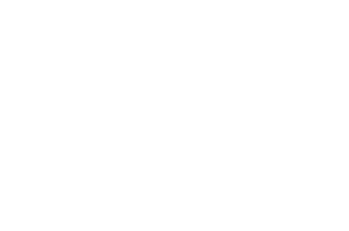

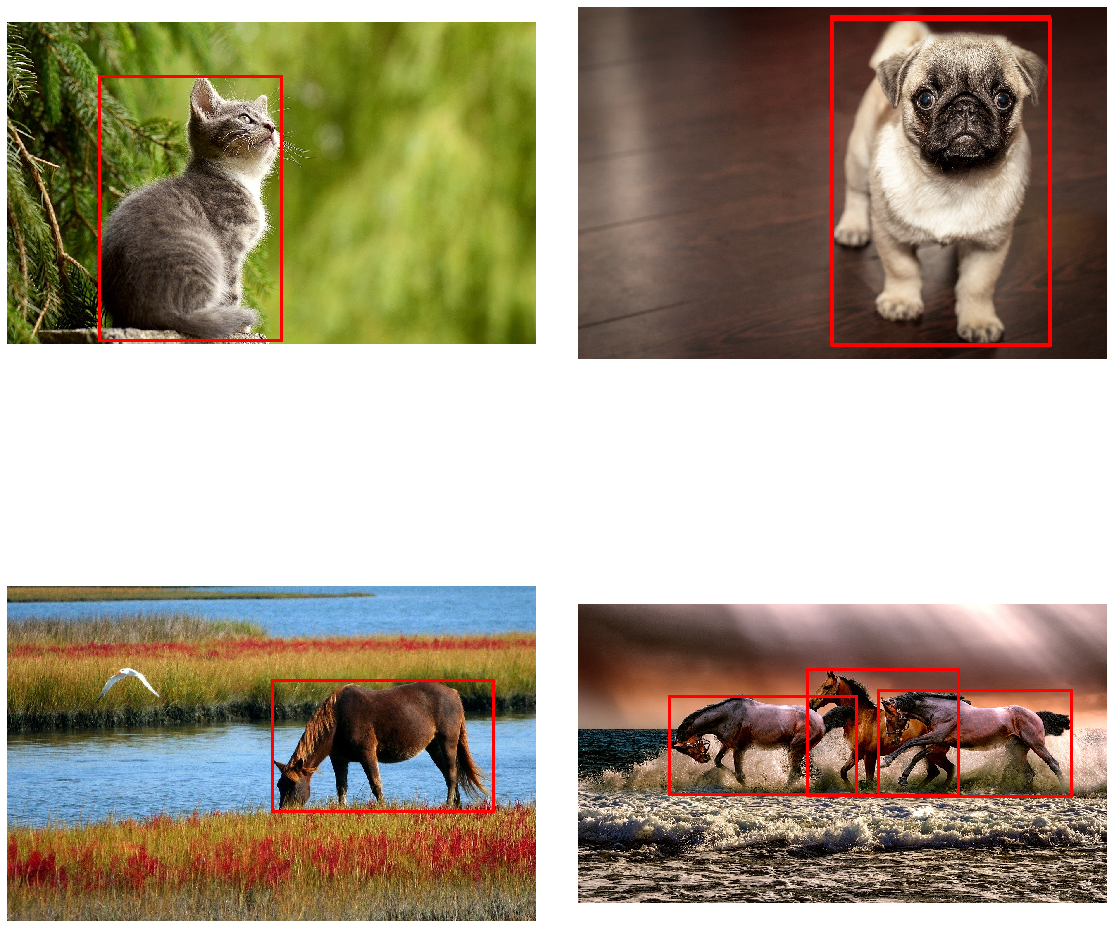

In [11]:
# run_and_show([18, 38, 54, 16])
run_and_show(pipe)

In [29]:
@pipeline_def(batch_size=batch_size, num_threads=4, device_id=0, seed=42)
def aug_pipe():
    jpegs, bboxes, labels, polygons, vertices = fn.readers.coco(
        file_root=file_root,
        images=['cat-2083492_1280.jpg', 'pug-690566_1280.jpg', 'horse-60153_1280.jpg', 'animal-3099035_1280.jpg'],
        annotations_file=annotations_file,
        polygon_masks=True,
        ratio=True)
    images = fn.decoders.image(jpegs, device="mixed", output_type=types.RGB)
    pasted = fn.paste(images, paste_x = 0.2, paste_y = 0.2, ratio = 1.5, fill_value=(118, 185, 0), device="gpu")
    flipped = fn.flip(images, horizontal=True, device="gpu")
    anchor, shape, bbox_cut, label = fn.random_bbox_crop(bboxes, labels, bbox_layout="xyWH", scaling=[0.5, 0.75], 
                                                         thresholds=[0.5, 0.25, 0.125, 0.025], num_attempts=10, allow_no_crop=False)
    sliced = fn.slice(images, anchor, shape)
    return images, pasted, flipped, sliced, bboxes, bbox_cut, labels, polygons, vertices        
pipe2 = aug_pipe()
pipe2.build()

In [42]:
def run_and_show_augs(pipe, selection=None):
    images, pasted, flipped, sliced, bboxes, bbox_cut, labels, polygons, vertices = pipe.run()
    idx = 0
    images_cpu = [images.as_cpu().at(idx),  pasted.as_cpu().at(idx), 
                  flipped.as_cpu().at(idx), sliced.as_cpu().at(idx)]
    bboxes_cpu = [bboxes.at(idx), bboxes.at(idx), bboxes.at(idx), bboxes.at(idx)]
    num_elements = len(images_cpu)
    # doesn't matter
    labels_cpu = [[0]] * num_elements
    polygons_cpu = [[0]] * num_elements
    vertices_cpu = [[0]] * num_elements
    
    show_imgs(images_cpu, bboxes_cpu, labels_cpu, polygons_cpu, vertices_cpu, 0, num_elements)
    # doesn't matter
#     labels_cpu = labels
#     polygons_cpu = polygons
#     vertices_cpu = vertices
# #     show_imgs_list(images_cpu, bboxes_cpu, labels_cpu, polygons_cpu, vertices_cpu, i, i+8)
#     if selection is None:
#         for i in range(0, batch_size, 8):
#             show_imgs(images_cpu, bboxes_cpu, labels_cpu, polygons_cpu, vertices_cpu, i, min(i+8, batch_size))
#     else:
#         show_imgs_list(images_cpu, bboxes_cpu, labels_cpu, polygons_cpu, vertices_cpu, selection)

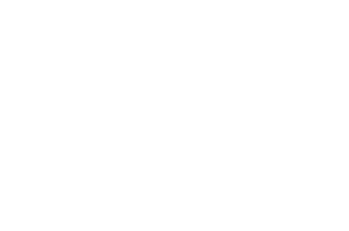

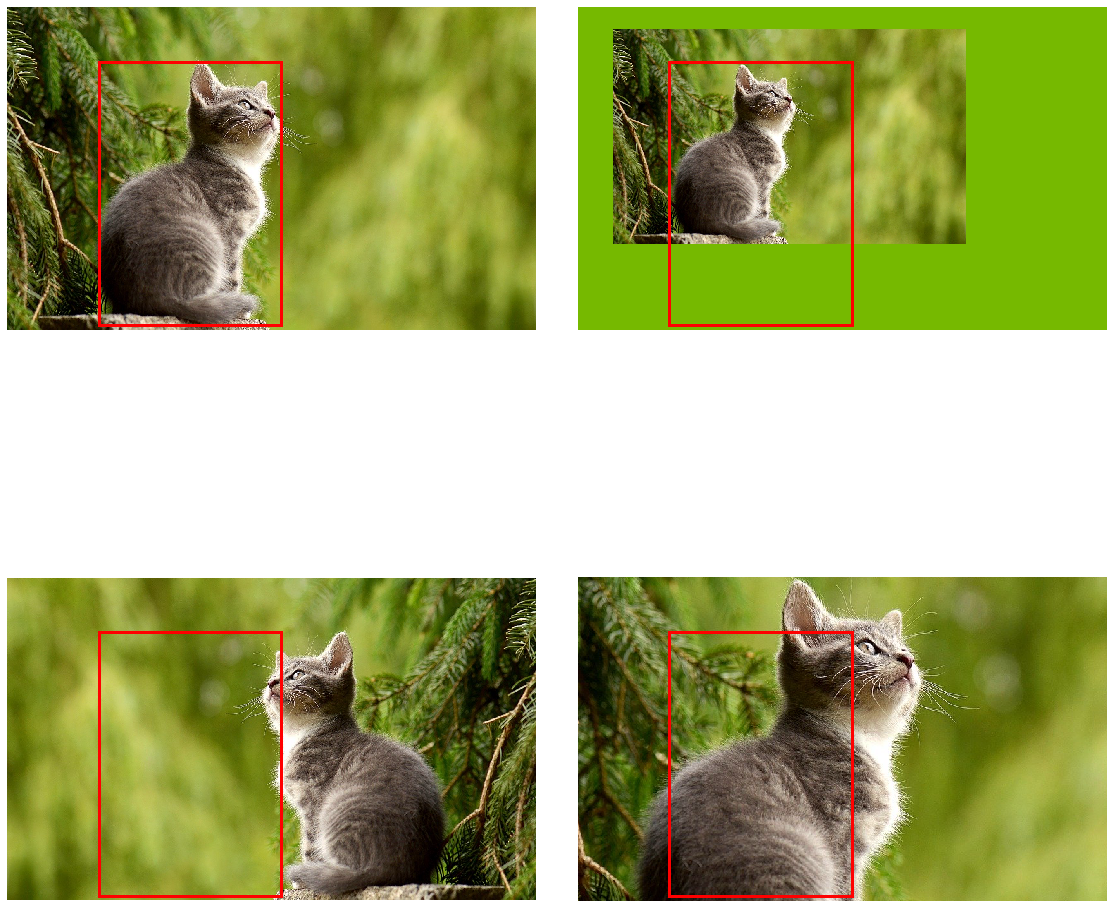

In [43]:
run_and_show_augs(pipe2)

[array([[0.17265625, 0.16901408, 0.34453124, 0.815621  ]], dtype=float32), array([[0.18177083, 0.17934272, 0.2296875 , 0.54374737]], dtype=float32), array([[0.48281252, 0.16901408, 0.34453124, 0.815621  ]], dtype=float32), array([[0.0000000e+00, 1.4477954e-04, 4.8635003e-01, 9.9985522e-01]],
      dtype=float32), array([[0.        , 0.14983852, 0.2290858 , 0.83350027]], dtype=float32), array([[0.        , 0.14983852, 0.2290858 , 0.83350027]], dtype=float32)]


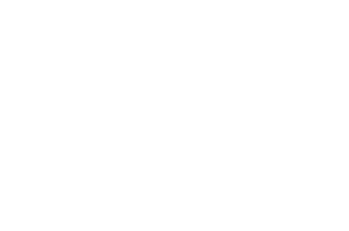

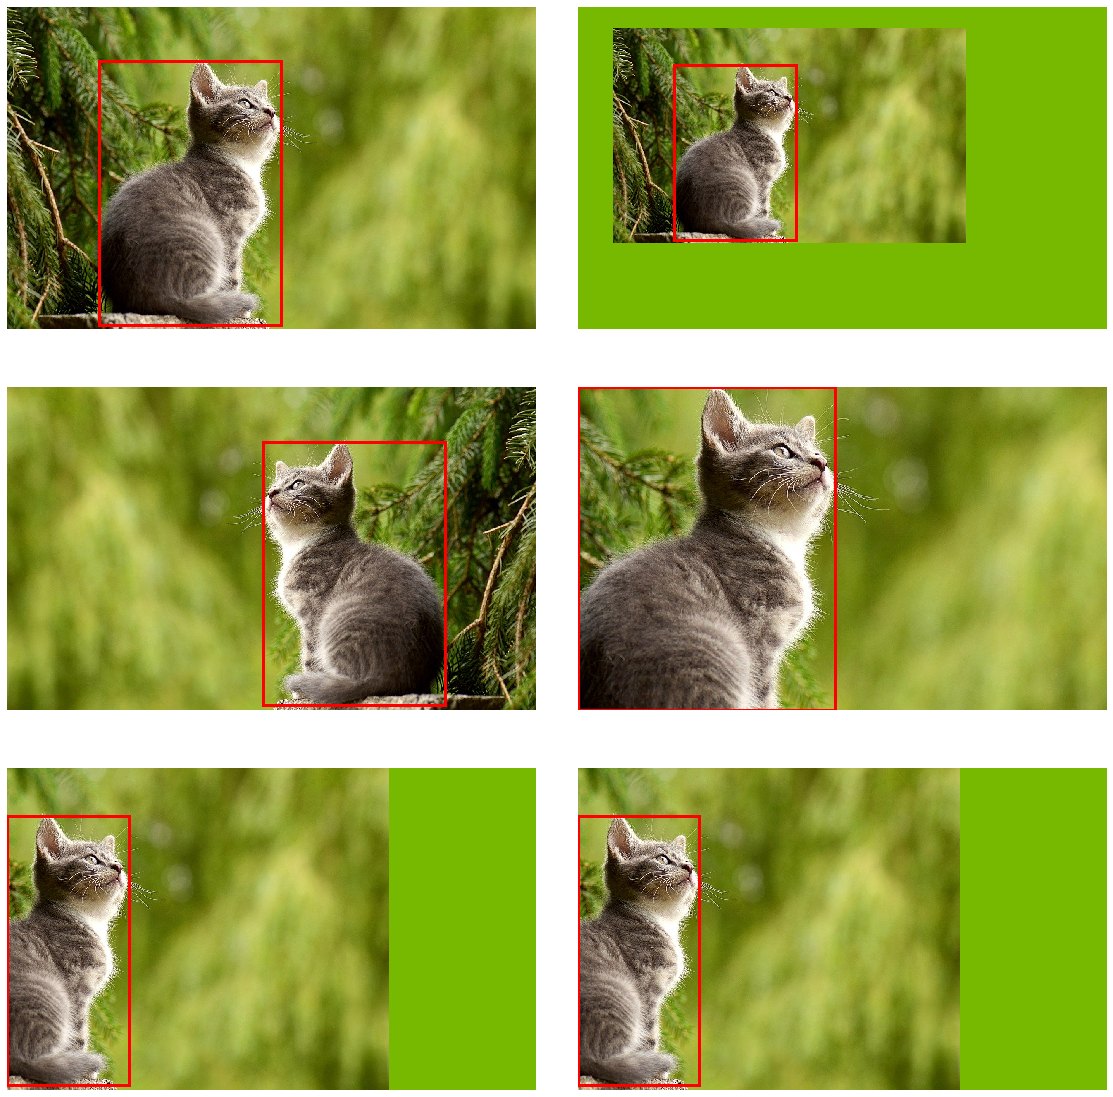

In [39]:
@pipeline_def(batch_size=batch_size, num_threads=4, device_id=0, seed=42)
def aug_bbox_pipe():
    jpegs, bboxes, labels, polygons, vertices = fn.readers.coco(
        file_root=file_root,
        images=['cat-2083492_1280.jpg', 'pug-690566_1280.jpg', 'horse-60153_1280.jpg', 'animal-3099035_1280.jpg'],
        annotations_file=annotations_file,
        polygon_masks=True,
        ratio=True)
    images = fn.decoders.image(jpegs, device="mixed", output_type=types.RGB)
    pasted = fn.paste(images, paste_x=0.2, paste_y=0.2, ratio=1.5, fill_value=(118, 185, 0), device="gpu")
    pbox = fn.bbox_paste(bboxes, paste_x=0.2, paste_y=0.2, ratio=1.5,)
    flipped = fn.flip(images, horizontal=True, device="gpu")
    fbox = fn.bb_flip(bboxes, horizontal=True)
    # We don't have a rotate ...
    # rotate = fn.rotate(images, angle=-50, device="gpu")
    # rot_mat = fn.transforms.rotation(angle=-50)
    # rbox = fn.coord_transform(bboxes, MT=rot_mat)
    
    anchor, shape, bbox_cut, label = fn.random_bbox_crop(bboxes, labels, bbox_layout="xyWH", scaling=[0.5, 0.75],
                                                         thresholds=[0.5, 0.25, 0.125, 0.025], num_attempts=10, allow_no_crop=False)
    sliced = fn.slice(images, anchor, shape)
    
    anchor2, shape2, bbox_cut2, label2 = fn.random_bbox_crop(pbox, labels, bbox_layout="xyWH", scaling=[0.5, 0.75],
                                                         thresholds=[0.5, 0.25, 0.125, 0.025], num_attempts=10, allow_no_crop=False)
    sliced2 = fn.slice(pasted, anchor2, shape2)
    
    return images, pasted, flipped, sliced, sliced2, bboxes, pbox, fbox, bbox_cut, bbox_cut2, labels, polygons, vertices        
pipe3 = aug_bbox_pipe()
pipe3.build()

def run_and_show_augs_bbox(pipe, selection=None):
    images, pasted, flipped, sliced, sliced2, bboxes, pbox, fbox, bbox_cut, bbox_cut2, labels, polygons, vertices = pipe.run()
    idx = 0
    images_cpu = [images.as_cpu().at(idx),  pasted.as_cpu().at(idx), 
                  flipped.as_cpu().at(idx), sliced.as_cpu().at(idx),
                  sliced2.as_cpu().at(idx), sliced2.as_cpu().at(idx)]
    bboxes_cpu = [bboxes.at(idx), pbox.at(idx), fbox.at(idx), bbox_cut.at(idx),
                  bbox_cut2.at(idx), bbox_cut2.at(idx)]
    print(bboxes_cpu)
    num_elements = len(images_cpu)
    # doesn't matter
    labels_cpu = [[0]] * num_elements
    polygons_cpu = [[0]] * num_elements
    vertices_cpu = [[0]]bbox_layout * num_elements
    
    show_imgs(images_cpu, bboxes_cpu, labels_cpu, polygons_cpu, vertices_cpu, 0, num_elements)
#     show_imgs_list(images_cpu, bboxes_cpu, labels_cpu, polygons_cpu, vertices_cpu, i, i+8)
#     if selection is None:
#         for i in range(0, batch_size, 8):
#             show_imgs(images_cpu, bboxes_cpu, labels_cpu, polygons_cpu, vertices_cpu, i, min(i+8, batch_size))
#     else:
#         show_imgs_list(images_cpu, bboxes_cpu, labels_cpu, polygons_cpu, vertices_cpu, selection)

run_and_show_augs_bbox(pipe3)